In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
^C
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras


In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive/EMNIST"


EMNIST2A@khap.ipynb
emnist-byclass-test-images-idx3-ubyte
emnist-byclass-test-images-idx3-ubyte.gz
emnist-byclass-test-labels-idx1-ubyte
emnist-byclass-train-images-idx3-ubyte
emnist-byclass-train-labels-idx1-ubyte
mnist1A.ipynb


In [0]:
!ls -lh "/content/gdrive/My Drive/EMNIST/emnist-byclass-test-images-idx3-ubyte"

-rw------- 1 root root 87M Jul  2 20:06 '/content/gdrive/My Drive/EMNIST/emnist-byclass-test-images-idx3-ubyte'


In [0]:
!pip install mnist


In [0]:
from mnist import *
import os,gzip

def loadfile(fname, target_dir=None, force=False):
    """Download the IDX file named fname from the URL specified in dataset_url
    and return it as a numpy array.
    Parameters
    ----------
    fname : str
        File name to download and parse
    target_dir : str
        Directory where to store the file
    force : bool
        Force downloading the file, if it already exists
    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file
    """
    #fname = download_file(fname, target_dir=target_dir, force=force)
    fname = "/content/gdrive/My Drive/EMNIST/" + fname
    fopen = gzip.open if os.path.splitext(fname)[1] == '.gz' else open
    with fopen(fname, 'rb') as fd:
      return parse_idx(fd)
  
  

X_train= loadfile("emnist-byclass-train-images-idx3-ubyte")
y_train = loadfile("emnist-byclass-train-labels-idx1-ubyte")

X_test = loadfile("emnist-byclass-test-images-idx3-ubyte")
y_test = loadfile("emnist-byclass-test-labels-idx1-ubyte")
  


<function matplotlib.pyplot.show>

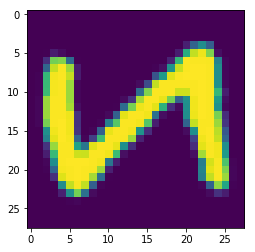

In [0]:
from matplotlib import pyplot as plt
#Display a random image
plt.imshow(X_train[0])
plt.show

In [0]:
#packages required
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM,BatchNormalization
from keras import backend as K
from keras.constraints import maxnorm
import numpy as np
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.


In [0]:
img_r,img_c=28,28
if K.image_data_format()=='channels_first':
        X_train=X_train.reshape(X_train.shape[0],1,img_r,img_c)
        X_test=X_test.reshape(X_test.shape[0],1,img_r,img_c)
        input_shape=(1,img_r,img_c)
else :
    X_train=X_train.reshape(X_train.shape[0],img_r,img_c,1)
    X_test=X_test.reshape(X_test.shape[0],img_r,img_c,1)
    input_shape=(img_r,img_c,1)

X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train/=255
X_test/=255
y_train=keras.utils.to_categorical(y_train,62)
y_test=keras.utils.to_categorical(y_test,62)


In [0]:
#model1A
b_size=64
epochs=20
model=Sequential()
model.add(Conv2D(32,kernel_size=(7,7),padding="same",activation='relu',input_shape=input_shape))
model.add(BatchNormalization(axis=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(5,5),padding="same",activation='relu'))
model.add(BatchNormalization(axis=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu',))
model.add(BatchNormalization(axis=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(62,activation='softmax'))
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam,metrics=['accuracy'])
history=model.fit(X_train ,y_train ,batch_size=b_size ,epochs=epochs ,verbose=1 ,validation_data=(X_test,y_test))
error=model.evaluate(X_test,y_test,verbose=0)

Train on 697932 samples, validate on 116323 samples
Epoch 1/20
697932/697932 [==============================] - 124s 177us/step - loss: 0.5061 - acc: 0.8258 - val_loss: 0.3778 - val_acc: 0.8602
Epoch 2/20
697932/697932 [==============================] - 122s 175us/step - loss: 0.3970 - acc: 0.8552 - val_loss: 0.3620 - val_acc: 0.8657
Epoch 3/20
697932/697932 [==============================] - 122s 175us/step - loss: 0.3778 - acc: 0.8606 - val_loss: 0.3502 - val_acc: 0.8684
Epoch 4/20
697932/697932 [==============================] - 122s 175us/step - loss: 0.3677 - acc: 0.8636 - val_loss: 0.3463 - val_acc: 0.8703
Epoch 5/20
697932/697932 [==============================] - 122s 174us/step - loss: 0.3605 - acc: 0.8660 - val_loss: 0.3372 - val_acc: 0.8730
Epoch 6/20
697932/697932 [==============================] - 122s 175us/step - loss: 0.3556 - acc: 0.8671 - val_loss: 0.3384 - val_acc: 0.8715
Epoch 7/20
697932/697932 [==============================] - 122s 175us/step - loss: 0.3511 - acc

In [0]:
#model2A
Optdelta=keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

b_size=128
epochs=25
model=Sequential()
model.add(Conv2D(32,kernel_size=(7,7),activation='relu',input_shape=input_shape))
#model.add(BatchNormalization(axis=2))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),padding="same",activation='relu',))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128,(3,3),padding="same",activation='relu',))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(62,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=Optdelta,metrics=['accuracy'])
history=model.fit(X_train ,y_train ,batch_size=b_size ,epochs=epochs ,verbose=1 ,validation_data=(X_test,y_test))
error=model.evaluate(X_test,y_test,verbose=0)

Train on 697932 samples, validate on 116323 samples
Epoch 1/25
697932/697932 [==============================] - 63s 90us/step - loss: 0.5454 - acc: 0.8152 - val_loss: 0.4064 - val_acc: 0.8562
Epoch 2/25
697932/697932 [==============================] - 62s 88us/step - loss: 0.3977 - acc: 0.8548 - val_loss: 0.3801 - val_acc: 0.8612
Epoch 3/25
697932/697932 [==============================] - 62s 88us/step - loss: 0.3820 - acc: 0.8591 - val_loss: 0.3709 - val_acc: 0.8620
Epoch 4/25
697932/697932 [==============================] - 62s 88us/step - loss: 0.3745 - acc: 0.8620 - val_loss: 0.3607 - val_acc: 0.8661
Epoch 5/25
697932/697932 [==============================] - 62s 88us/step - loss: 0.3709 - acc: 0.8628 - val_loss: 0.3741 - val_acc: 0.8628
Epoch 6/25
697932/697932 [==============================] - 62s 89us/step - loss: 0.3683 - acc: 0.8638 - val_loss: 0.3604 - val_acc: 0.8666
Epoch 7/25
697932/697932 [==============================] - 62s 88us/step - loss: 0.3670 - acc: 0.8643 - val

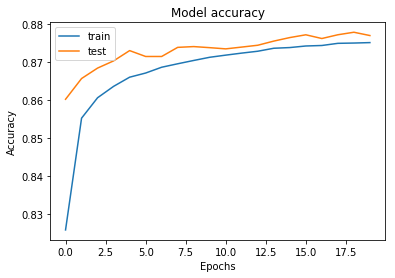

In [0]:
#accuracy and loss history visualization
#print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()
import h5py
model.save('emnist_custom2.h5')
model.save_weights('custom2_model_weights.h5')

In [0]:
import h5py
x=0
train_prev=0
train_next=38774
hf = h5py.File('/content/gdrive/My Drive/EMNIST/data-X-train%x'%x+'.h5', 'w')
hf.create_dataset('dataset_1', data=X_train[train_prev:train_next,:,:,:])
hf.close()
or x in range(18):
    hf = h5py.File('/content/gdrive/My Drive/EMNIST/data-X-train%x'%x+'.h5', 'w')
    hf.create_dataset('dataset_1', data=X_train[train_prev:train_next,:,:,:])
    hf.close()

    hf = h5py.File('/content/gdrive/My Drive/EMNIST/data-y-train%x'%x+'.h5', 'w')
    hf.create_dataset('dataset_1', data=y_train[train_prev:train_next,:])
    hf.close()

    train_prev=train_next
    train_next=train_next+38774


    hf = h5py.File('/content/gdrive/My Drive/EMNIST/data-X-test%x'%x+'.h5', 'w')
    hf.create_dataset('dataset_1', data=X_test[test_prev:test_next,:,:,:])
    hf.close()

    hf = h5py.File('/content/gdrive/My Drive/EMNIST/data-y-test%x'%x+'.h5', 'w')
    hf.create_dataset('dataset_1', data=y_test[test_prev:test_next,:])
    hf.close()

    test_prev=test_next 
    test_next=test_next+6462
    print(test_next)